# Stereo visual odometry

This notebook presents the algorithm for stereo visual odometry for the example of the camera movement between the first two frames of seqence 00 of kitti odometry dataset. To see a animation for up to 1000 frames, please run the python file main.py or watch the video. 


The code uses the KITTI odometry dataset. To make things easier, we uploaded the data for the first 1000 frames of sequence 00 together with our code.

In [21]:
import pykitti
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as optimization
import cv2
from matplotlib.colors import LogNorm
from visualodfunctions import * #these are our functions

In file visualodfunctions, you find all our functions.

parameters to change:

In [22]:
basedir='/home/user/Downloads/data_odometry_gray/dataset_small/' #insert the path to dataset here
sequence = '00'
num_imgs=2
useransac=True #if False, clique inlier detection is used, if True, RANSAC is used

initialize everything

In [23]:
dataset = pykitti.odometry(basedir, sequence, frames=range(num_imgs))
f     =7.188560000000e+02  # lense focal length from calibration file
baseline = dataset.calib.b_gray  # distance in m between the two cameras

cl=iter(dataset.cam0)
cr=iter(dataset.cam1)
posestrue=dataset.poses[0:num_imgs]
PM=dataset.calib.P_rect_00
points=np.zeros((1,0,2))
RTtot=np.eye(4)
posesxz=np.zeros((2, num_imgs))
posesxztrue=np.zeros((2, num_imgs))

The basic algorithm is as follows: for a given pair of frames, (1) detect features in the left image of the first frame (corner detection), (2) track the features to the second frame, (3) calculate disparity and depthmap for the image, especially for the feature points using the right image (4) project the points to  3D using the depths (5) find the largest set of self of consistent matches (inliers), and (6) find the frame-to-frame motion that minimizes the re-projection error for features in the inlier set. 

image number 0


/tmp/ipykernel_8014/1287205481.py:18: RuntimeWarning: divide by zero encountered in true_divide
  depthL = f / disparityL * baseline  # images are stereo rectified
/tmp/ipykernel_8014/1287205481.py:22: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  depthLpts = depthL.T[coordlist]


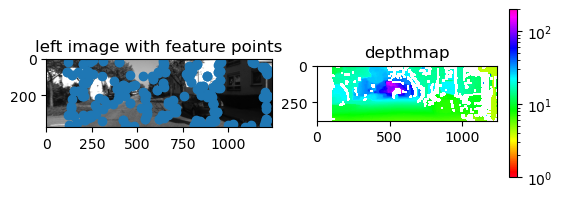

image number 1


/tmp/ipykernel_8014/1287205481.py:15: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  points = points[point_in_img_mask]
/tmp/ipykernel_8014/1287205481.py:16: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  worldptsold=worldptsold[point_in_img_mask]


total Rotation-translation matrix of camera:
RTtot=[[ 9.99989498e-01 -2.81142983e-03 -3.61947875e-03 -4.32636865e-04]
 [ 2.80503102e-03  9.99994496e-01 -1.77174436e-03 -1.14297213e-02]
 [ 3.62443997e-03  1.76157300e-03  9.99991880e-01  6.65086499e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


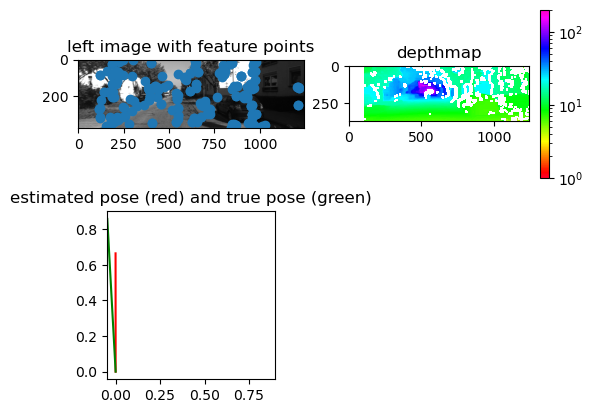

In [24]:
for i in range(num_imgs):
    print(f'image number {i}')
    right = np.array(next(cr))
    leftnew = np.array(next(cl))
    disparityL =compute_left_disparity_map(leftnew, right,
                               matcher='sgbm', verbose=True)
    if i==0:
        points=np.array(distract_keypoint(leftnew))
    if i>0:
        pointsold=np.copy(points)
        worldptsold=np.copy(worldpts)
        points,k, st=feature_tracking(left, leftnew, pointsold)
        point_in_img_mask=[(points[:,0,0]<np.shape(leftnew)[1]) & (points[:,0,1]<np.shape(leftnew)[0]) & (points[:,0,0]>0) & (points[:, 0, 1] > 0)]

        points = points[point_in_img_mask]
        worldptsold=worldptsold[point_in_img_mask]

    depthL = f / disparityL * baseline  # images are stereo rectified
    depthL[depthL > 200] = np.NaN
    depthL[depthL < 0] = np.NaN
    coordlist = list(points[:, 0, :].T.astype('int'))
    depthLpts = depthL.T[coordlist]
    points = points[np.isfinite(depthLpts)]
    if i>0:
        worldptsold=worldptsold[np.isfinite(depthLpts)]
    depthLpts = depthLpts[np.isfinite(depthLpts)]
    worldpts=screen2cam(points,depthLpts,PM)
    left=leftnew
    plt.subplot(2,2,1)
    plt.cla()
    plt.imshow(left,cmap=plt.get_cmap('gray'))
    plt.title('left image with feature points')
    plt.scatter(points[:,0,0],points[:,0,1])
    plt.subplot(2,2,2)

    plt.imshow(depthL,cmap=plt.get_cmap('gist_rainbow'),norm=LogNorm(vmin=1, vmax=200))
    plt.title('depthmap')
    plt.colorbar()
    if i>0:
        if useransac==False:
            params0=RANSAC(points, worldptsold, PM)
        else:
            pointslsq,worldptsoldlsq, worldptslsq=inlierdetection(points, worldptsold, worldpts)
            if i>1:
                x0=params0.x
            else:
                x0=np.zeros(6)
            params0 = optimization.least_squares(fun=errfct, x0=x0, args=(worldptsoldlsq,pointslsq,PM),method='lm')
        RT=createRT(params0.x[0],params0.x[1],params0.x[2],params0.x[3],params0.x[4],params0.x[5])
        RTtot=RTtot @ np.linalg.inv(RT)
        print('total Rotation-translation matrix of camera:')
        print(f'RTtot={RTtot}')
        plt.subplot(2,2,3)
        posesxz[:,i]=RTtot[[0,2],3]
        posesxztrue[:,i]=posestrue[i][[0,2],3]
        plt.cla()
        plt.plot(posesxz[0,:(i+1)],posesxz[1,:(i+1)] ,color='r')
        plt.plot(posesxztrue[0, :(i + 1)], posesxztrue[1, :(i + 1)],color='g')
        #plt.xlim([-100,100])
        #plt.ylim([-5, 195])
        plt.axis('square')
        plt.title('estimated pose (red) and true pose (green)')
    if len(points)<100:
        points = np.vstack([points,np.array(distract_keypoint(leftnew))])
        coordlist = list(points[:, 0, :].T.astype('int'))
        depthLpts = depthL.T[coordlist]
        points = points[np.isfinite(depthLpts)]
        depthLpts = depthLpts[np.isfinite(depthLpts)]
        worldpts = screen2cam(points, depthLpts, PM)
        print('detect new points')

    plt.show()
